# BN Generation Parameter Sweep

This notebook sweeps over DAG/BN generation parameters outlined in `notebooks/graph_generation/ideas.md` and materializes multiple discrete BN variants per DAG.

It varies:
- n (number of variables)
- target treewidth
- variable arity (fixed or range)
- CPT skewness (Dirichlet alpha)
- determinism fraction (mostly 0%)

Outputs:
- CSV with per-variant metadata
- On-screen CPT previews for a small sample



In [18]:
import sys
from pathlib import Path
import re
from os import getenv

# Ensure src is importable
repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from graph_generation import generate_dag_with_treewidth
from bn_generation import generate_variants_for_dag
from cpd_utils import cpd_to_ascii_table
from discrete.discrete_inference import format_probability_query, query_probability
from llm_calling import run_llm_call
from yaml_utils import load_yaml

import pandas as pd
import numpy as np
from openai import OpenAI

# Import query complexity functions and BN generation function from bn_query_sweep module
from bn_query_sweep import compute_query_complexity, compute_all_query_complexities, generate_bayesian_networks_and_metadata


In [23]:
# LLM Configuration and Helper Functions
# GLOBAL TOGGLE: Set to False to disable all LLM calls
ENABLE_LLM_CALLS = False

MODEL = "deepseek/deepseek-chat-v3.1:free"
MODEL = "openai/gpt-5"
MODEL = "openai/o3-mini-high"  

# Initialize OpenAI client (only if LLM calls are enabled)
if ENABLE_LLM_CALLS:
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=getenv("OPENROUTER_API_KEY")
    )
else:
    client = None
    print("LLM calls are DISABLED. Set ENABLE_LLM_CALLS = True to enable.")

# Load prompts
prompt_path = repo_root / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)
# Import the functions from llm_calling instead of defining them here
from llm_calling import extract_numeric_answer, create_probability_prompt, run_llm_call 


LLM calls are DISABLED. Set ENABLE_LLM_CALLS = True to enable.


In [24]:
# Parameter grids (edit as needed)
#ns = [7, 11, 15]
#ns = [25]
ns = [9, 11]
#treewidths = [2, 3, 4]
#treewidths = [5]
treewidths = [3, 5, 7]
arity_specs = [
    #{"type": "fixed", "fixed": 2},
    {"type": "range", "min": 2, "max": 3},
]
#dirichlet_alphas = [0.5, 1.0]
dirichlet_alphas = [1.0, 0.5]
#determinism_fracs = [0.0, 0.1]  # mostly 0%; includes a nonzero test
determinism_fracs = [0.0]  # mostly 0%; includes a nonzero test
#naming_strategies = ['simple', 'confusing', 'semantic']  # Add naming strategy variation
#naming_strategies = ['simple', 'confusing']  # Add naming strategy variation
naming_strategies = ['confusing']  # Add naming strategy variation
variants_per_combo = 4
base_seed = 42

rows = []
preview_samples = []

sample_counter = 0
all_bayesian_networks = []  # Store all BNs and their metadata

In [25]:
# Generate Bayesian networks and populate metadata using the centralized function
all_bayesian_networks, rows, preview_samples = generate_bayesian_networks_and_metadata(
    ns=ns,
    treewidths=treewidths,
    arity_specs=arity_specs,
    dirichlet_alphas=dirichlet_alphas,
    determinism_fracs=determinism_fracs,
    naming_strategies=naming_strategies,
    variants_per_combo=variants_per_combo,
    base_seed=base_seed,
    max_preview_samples=3
)

print(f"Generated {len(all_bayesian_networks)} Bayesian networks")
print(f"Created {len(rows)} metadata rows")
print(f"Collected {len(preview_samples)} preview samples")

df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")
out_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep.csv'

Generated 48 Bayesian networks
Created 48 metadata rows
Collected 12 preview samples


,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9
1,9,3,3,confusing,range:2-3,1.0,0.0,10015,1,12,9
2,9,3,3,confusing,range:2-3,1.0,0.0,19988,2,12,9
3,9,3,3,confusing,range:2-3,1.0,0.0,29961,3,12,9
4,9,3,3,confusing,range:2-3,0.5,0.0,43,0,12,9


Total variants: 48


In [26]:
# For each Bayesian network, generate n queries using generate_queries, run them, and collect results
from query_generation import generate_queries
from pgmpy.inference import VariableElimination

# Store all queries for later recovery: a list of lists (per BN)
all_bn_queries = []

query_rows = []

for idx, bn_dict in enumerate(all_bayesian_networks):
    bn = bn_dict["bn"]
    # Use a different seed per BN for query generation for reproducibility
    query_seed = 1000 + idx
    # Generate queries for this BN
    queries = generate_queries(
        bn,
        num_queries=24,
        query_node_counts=(1, 2),
        #query_node_counts=[2],
        evidence_counts=(0, 1, 2),
        #evidence_counts=(2),
        #distance_buckets=[(1, 1), (2, 3), (1, 3)],
        distance_buckets=[(2, 3)],
        seed=query_seed,
    )
    all_bn_queries.append(queries)
    # Get the BN's properties from the main df
    bn_row = df.iloc[idx].to_dict()
    for qidx, query in enumerate(queries):
        # Prepare inference
        infer = VariableElimination(bn)
        # Query variables and their states
        query_vars = [v for v, _ in query.targets]
        query_states = [s for _, s in query.targets]
        # Evidence dict: variable -> state
        evidence = query.evidence if query.evidence else None

        # Compute exact probability (with evidence)
        try:
            result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
            assignment = dict(zip(query_vars, query_states))
            prob = result.get_value(**assignment)
        except Exception as e:
            prob = None

        # Compute prior probability (no evidence)
        try:
            prior_result = infer.query(variables=query_vars, evidence=None, show_progress=False)
            prior_assignment = dict(zip(query_vars, query_states))
            prior_prob = prior_result.get_value(**prior_assignment)
        except Exception as e:
            prior_prob = None

        # Collect all info for the table, merging BN and query properties (no LLM here)
        row = dict(bn_row)  # copy BN properties
        row.update({
            "bn_index": idx,
            "query_index": qidx,
            "query_vars": str(query_vars),
            "query_states": str(query_states),
            "evidence": str(query.evidence),
            "distance": query.meta.get("min_target_evidence_distance"),
            "num_evidence": query.meta.get("num_evidence_nodes"),
            "probability": prob,
            "prior_probability": prior_prob,  # add the prior probability as a new column
        })
        query_rows.append(row)

# Convert to DataFrame and display
full_df = pd.DataFrame(query_rows)
print(f"Total queries: {len(full_df)}")

Total queries: 1152


In [27]:
full_df

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes,bn_index,query_index,query_vars,query_states,evidence,distance,num_evidence,probability,prior_probability
0,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9,0,0,[np.str_('K_kx9xcv')],['s2'],{np.str_('O_gh8nq9'): 's1'},2,1,0.659776,0.383399
1,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9,0,1,[np.str_('Z_7j9n4o')],['s1'],{},0,0,0.365964,0.365964
2,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9,0,2,[np.str_('Z_7j9n4o')],['s0'],{},0,0,0.634036,0.634036
3,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9,0,3,[np.str_('O_cguird')],['s2'],"{np.str_('O_gh8nq9'): 's2', np.str_('Y_nizbt1'...",2,2,0.546029,0.531625
4,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9,0,4,[np.str_('O_cguird')],['s0'],"{np.str_('Z_7j9n4o'): 's1', np.str_('Y_nizbt1'...",3,2,0.280148,0.305760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,11,47,19,"[np.str_('W_zz5knb'), np.str_('V_muljqw')]","['s1', 's1']",{},0,0,0.096360,0.096360
1148,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,11,47,20,[np.str_('A_04jxrk')],['s0'],"{np.str_('X_m2d46j'): 's1', np.str_('F_nhuh63'...",2,2,0.460761,0.437535
1149,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,11,47,21,[np.str_('F_nhuh63')],['s1'],{},0,0,0.368003,0.368003
1150,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,11,47,22,"[np.str_('X_m2d46j'), np.str_('F_nhuh63')]","['s0', 's1']",{np.str_('V_muljqw'): 's1'},1,1,0.141513,0.131975


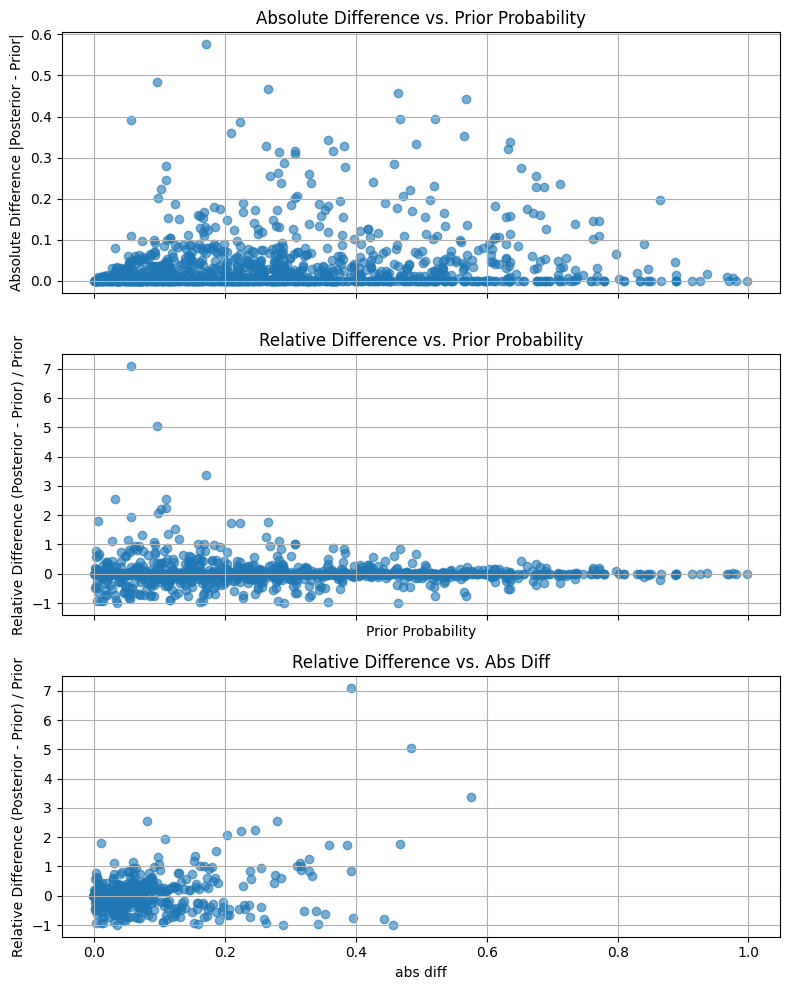

In [28]:
import matplotlib.pyplot as plt
import numpy as np

prior = full_df["prior_probability"].astype(float)
posterior = full_df["probability"].astype(float)

# Mask out rows where prior or posterior is NaN
mask = ~(prior.isna() | posterior.isna())
prior = prior[mask]
posterior = posterior[mask]

abs_diff = np.abs(posterior - prior)
# Avoid division by zero; mask entries where prior=0 for rel_diff
with np.errstate(divide='ignore', invalid='ignore'):
    rel_diff = np.where(prior != 0, (posterior - prior) / prior, np.nan)

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Absolute difference plot
axs[0].scatter(prior, abs_diff, alpha=0.6)
axs[0].set_ylabel("Absolute Difference |Posterior - Prior|")
axs[0].set_title("Absolute Difference vs. Prior Probability")
axs[0].grid(True)

# Relative difference plot
axs[1].scatter(prior, rel_diff, alpha=0.6)
axs[1].set_xlabel("Prior Probability")
axs[1].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[1].set_title("Relative Difference vs. Prior Probability")
axs[1].grid(True)


axs[2].scatter(abs_diff, rel_diff, alpha=0.6)
axs[2].set_xlabel("abs diff")
axs[2].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[2].set_title("Relative Difference vs. Abs Diff")
axs[2].grid(True)


plt.tight_layout()
plt.show()


In [ ]:
# Choose a row index from full_df to analyze
test_row_index = 0  # Change this to any valid row index

print("=" * 80)
print(f"TESTING QUERY-SPECIFIC COMPLEXITY COMPUTATION FOR ROW {test_row_index}")
print("=" * 80)

# Compute complexity for the selected row
complexity_result = compute_query_complexity(full_df, all_bayesian_networks, test_row_index, verbose=True)

print("\n" + "=" * 80)
print("DETAILED COMPLEXITY METRICS:")
print("=" * 80)

# Display the results in a nice format
for key, value in complexity_result.items():
    if key not in ['elimination_order', 'complete_elimination_order', 'factor_sizes', 'query_vars', 'query_states', 'evidence', 'keep_vars', 'eliminate_vars']:
        print(f"{key:25}: {value}")
    elif key in ['elimination_order', 'complete_elimination_order']:
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    elif key == 'factor_sizes':
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    else:
        print(f"{key:25}: {value}")

print("\n" + "=" * 80)
print("FACTOR SIZE PROGRESSION:")
print("=" * 80)
for i, size in enumerate(complexity_result['factor_sizes']):
    print(f"Step {i+1:2d}: {size:8,} entries")

print("\n" + "=" * 80)
print("QUERY-SPECIFIC ANALYSIS:")
print("=" * 80)
print(f"Query variables kept: {complexity_result['keep_vars']}")
print(f"Variables eliminated: {complexity_result['eliminate_vars']}")
print(f"Variables eliminated: {complexity_result['num_eliminated_vars']}/{complexity_result['num_vars']} ({complexity_result['num_eliminated_vars']/complexity_result['num_vars']*100:.1f}%)")

complexity_df = compute_all_query_complexities(full_df, all_bayesian_networks, verbose=True)
print("\nComplexity DataFrame:")
display(complexity_df.head())

In [ ]:
# Summary of query complexities and their relation to Bayesian network treewidth

import matplotlib.pyplot as plt

# Workaround: Add achieved_tw to complexity_df by joining with rows metadata if missing
if 'achieved_tw' not in complexity_df.columns:
    # Try to import the metadata rows (used in sweep code)
    # This block expects all_bayesian_networks and their 'meta'
    try:
        # Find which DataFrame in our namespace has 'achieved_tw'
        # Typically "rows" or maybe "full_df" has this info
        if 'rows' in globals():
            meta_df = pd.DataFrame(rows)
        else:
            # Try to get the meta attributes via all_bayesian_networks
            meta_df = pd.DataFrame([bn['meta'] for bn in all_bayesian_networks])
        # Try to align row indices between complexity_df and meta_df; use 'bn_index' if available
        if 'bn_index' in complexity_df.columns:
            meta_df = meta_df.reset_index().rename(columns={'index': 'bn_index'})
            merged_df = complexity_df.merge(meta_df[['bn_index', 'achieved_tw']], on='bn_index', how='left')
        elif 'row_index' in complexity_df.columns:
            meta_df = meta_df.reset_index().rename(columns={'index': 'row_index'})
            merged_df = complexity_df.merge(meta_df[['row_index', 'achieved_tw']], on='row_index', how='left')
        else:
            # fallback: just concat if lengths match
            if len(meta_df) == len(complexity_df):
                merged_df = complexity_df.copy()
                merged_df['achieved_tw'] = meta_df['achieved_tw']
            else:
                print("Warning: Could not align metadata with complexity_df. 'achieved_tw' will be missing.")
                merged_df = complexity_df
        complexity_df = merged_df
    except Exception as e:
        print("Could not add 'achieved_tw' to complexity_df:", e)

if 'achieved_tw' not in complexity_df.columns:
    print("Error: 'achieved_tw' column is missing from complexity_df and could not be merged. Summary cannot proceed.")
    summary_df = complexity_df.dropna(subset=['induced_width'])  # Only dropna on what we do have
else:
    summary_df = complexity_df.dropna(subset=['induced_width', 'achieved_tw'])

print("Summary of Query Complexities vs. Bayesian Network Treewidth")
print("-" * 70)
print("Number of queries analyzed:", len(summary_df))
if 'error' in summary_df.columns:
    print("Number of failed computations:", summary_df['error'].notna().sum())

if 'achieved_tw' in summary_df.columns:
    # Compute means grouped by achieved treewidth
    grouped = summary_df.groupby('achieved_tw').agg(
        mean_induced_width=('induced_width', 'mean'),
        std_induced_width=('induced_width', 'std'),
        mean_total_cost=('total_cost', 'mean'),
        mean_max_factor_size=('max_factor_size', 'mean'),
        num_queries=('induced_width', 'count'),
    )
    print("\nAverage query-specific induced width, total cost, and factor sizes by BN treewidth:")
    display(grouped)
    
    # Compare induced width to achieved treewidth
    plt.figure(figsize=(6, 4))
    plt.scatter(summary_df['achieved_tw'], summary_df['induced_width'], alpha=0.7)
    plt.plot(sorted(summary_df['achieved_tw'].unique()), sorted(summary_df['achieved_tw'].unique()), 'r--', label='BN treewidth')
    plt.xlabel("Achieved BN Treewidth")
    plt.ylabel("Query-Specific Induced Width")
    plt.title("Induced Width for Queries vs. BN Treewidth")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.scatter(summary_df['achieved_tw'], summary_df['total_cost'], alpha=0.7)
    plt.xlabel("Achieved BN Treewidth")
    plt.ylabel("Query Elimination Total Cost")
    plt.title("Total Cost vs. Achieved BN Treewidth (Query-Specific)")
    plt.grid(True)
    plt.show()
else:
    print("Skipping treewidth summary/grouped plots because 'achieved_tw' is unavailable in this DataFrame.")

# Textual summary
print("\nTextual Insights:")
print(
    " - Query-specific induced width is typically less than or equal to the overall BN treewidth (diagonal shown in red).\n"
    " - Variability arises due to evidence and targeted query variables, leading to factors smaller than the worst-case elimination.\n"
    " - Some queries are much easier than others on the same BN; induced width and computational cost are query- and evidence-dependent.\n"
    " - Cost and maximum factor sizes generally increase as BN treewidth increases, but not all queries are equally hard.\n"
    " - Review the scatter plots and group means above for your instances.\n"
)


In [ ]:
# Inspect a single row: draw BN, call LLM, compare\n
from bn_query_sweep import inspect_row_and_call_llm, call_llm_for_query
from pathlib import Path

if ENABLE_LLM_CALLS:
    # Choose a row index from full_df
    #row_index = 330
    row_index = 8

    result = inspect_row_and_call_llm(
        full_df=full_df,
        all_bayesian_networks=all_bayesian_networks,
        row_index=row_index,
        openai_client=client,
        model=MODEL,
        prompts_path=prompt_path,
        draw_kwargs={"figsize": (6, 4)},
    )
    print(result)

In [ ]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
# Import _parse_field from bn_query_sweep instead of defining it locally
from bn_query_sweep import _parse_field

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None

ENABLE_LLM_CALLS = True
if ENABLE_LLM_CALLS:
    # Select which rows to send to LLM (example below commented out)
    #selected_indices = list(full_df.sample(n=40, random_state=0).index)
    selected_indices = list(full_df.sample(n=2, random_state=0).index)
    #selected_indices = list(full_df.index)

    for ridx in selected_indices:
        row = full_df.iloc[ridx]
        bn = all_bayesian_networks[int(row['bn_index'])]['bn']
        query_vars = _parse_field(row['query_vars']) or []
        query_states = _parse_field(row['query_states']) or []
        evidence = _parse_field(row['evidence']) or None
        print(f"Processing BN {int(row['bn_index'])}/{len(all_bayesian_networks)}, Query {int(row['query_index'])}...")
        llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
        full_df.at[ridx, 'llm_probability'] = llm_prob
        full_df.at[ridx, 'llm_response'] = llm_response
else:
    print("LLM calls are disabled. Skipping batch LLM processing.")
    print(f"Would have processed {len(full_df)} queries if LLM calls were enabled.")

ENABLE_LLM_CALLS = False

In [ ]:
out_llm_csv = out_query_csv.with_name(out_query_csv.stem + "_with_llm.csv")
# Save the DataFrame with LLM responses to a CSV file
#out_llm_csv = out_query_csv.replace(".csv", "_with_llm.csv")
full_df.to_csv(out_llm_csv, index=False)
print("Saved DataFrame with LLM responses to", out_llm_csv)

In [ ]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)


In [ ]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

# Save enhanced results with LLM data
enhanced_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries_with_llm.csv'
full_df.to_csv(enhanced_csv, index=False)
print(f'Saved enhanced results with LLM data to {enhanced_csv}')

In [ ]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()].copy()
plot_df['abs_error'] = abs(plot_df['llm_probability'] - plot_df['probability'])

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")


In [ ]:
def compute_all_query_complexities(full_df, all_bayesian_networks, verbose=False):
    """
    Compute complexity metrics for all queries in full_df.
    
    Parameters:
    - full_df: DataFrame containing query information
    - all_bayesian_networks: List of BN dictionaries with 'bn' and 'meta' keys
    - verbose: If True, print progress information
    
    Returns:
    - pd.DataFrame: DataFrame with complexity metrics for each query
    """
    complexity_results = []
    
    for idx in range(len(full_df)):
        if verbose:
            print(f"Processing query {idx+1}/{len(full_df)}...")
        
        try:
            result = compute_query_complexity(full_df, all_bayesian_networks, idx, verbose=False)
            complexity_results.append(result)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            # Add a row with error information
            complexity_results.append({
                'row_index': idx,
                'error': str(e),
                'induced_width': None,
                'total_cost': None,
                'max_factor_size': None,
            })
    
    # Convert to DataFrame
    complexity_df = pd.DataFrame(complexity_results)
    
    if verbose:
        print(f"\nComputed complexity for {len(complexity_results)} queries")
        if 'error' in complexity_df.columns:
            successful = len(complexity_df[complexity_df['error'].isna()])
            failed = len(complexity_df[complexity_df['error'].notna()])
        else:
            successful = len(complexity_df)
            failed = 0
        print(f"Successful computations: {successful}")
        print(f"Failed computations: {failed}")
    
    return complexity_df


